# Lecture 8 worksheet

In [1]:
import numpy as np
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

## Question 1: Random sampling with numpy

For each of the following prompts, use distributions in `np.random.•••` (or `stats.•••.rvs`) to generate 100 samples from the specified distribution. Each answer should require no more than 5 lines of code.

### Q1.1

Generate samples from a 2-dimensional multivariate normal distribution with mean $(0, 3)$ and the given covariance matrix. Make a scatterplot where each axis corresponds to one of the two dimensions, and each sample is a single point. 

To help make the points more visible, use `alpha=0.2` as a keyword argument to the `scatter` function: this makes the drawn points more transparent so that it's easier to see when multiple points overlap. Do your results seem correct?

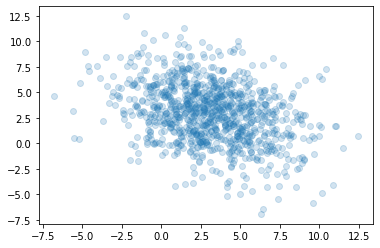

In [2]:
covariance = np.array([[9, -3], [-3, 9]])

samples = np.random.multivariate_normal([3, 3], covariance, 1000)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.2);

### Q1.2

Generate samples from the following model. You should use variables `z` and `x` for the samples of $z$ and $x$ respectively. For $z$, make sure you're generating samples from the correct parameters, and verify that the empirical distribution of your samples looks like the corresponding distribution on the [Wikipedia page for the Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). 

Draw a scatterplot of $x$ and $z$, and label your axes.

$$
z \sim \text{Gamma}(k=7.5, \theta=1.0)\\
x \sim N(0, 1/z)
$$

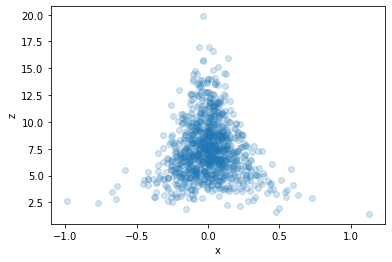

In [3]:
z = np.random.gamma(7.5, 1, 1000)
x = np.random.normal(0, 1/z)
plt.scatter(x, z, alpha=0.2)
plt.xlabel('x')
plt.ylabel('z');

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


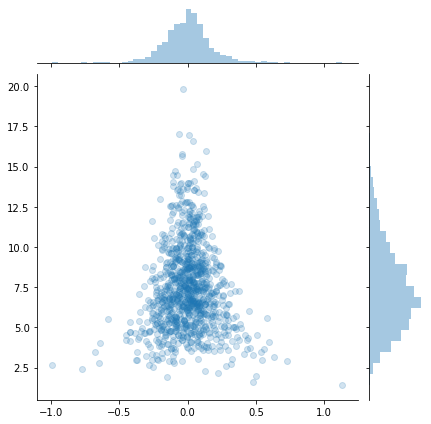

In [4]:
# Alternately:
import seaborn as sns
sns.jointplot(x, z, alpha=0.2)

## Question 2: Rejection sampling and normalizing constants

In this question, we'll revisit the distribution we used in Discussion 6.

$$p(\theta) = \frac{\log(2+\sin(a\theta))}{Z}$$

where $\theta \in [0, 4]$. Recall that we used numerical integration to estimate that if $a=4$, then $Z\approx 2.76$. We'll assume $a=4$ for the rest of this question, too.

For this question, we'll use a scaled unnormalized version of the distribution as our target, which we want to generate samples from:

$$p_\text{target} = M \log(2 + \sin(4\theta))$$

We'll see how our procedure changes as we pick different values for $M$.

### Q2.1

For rejection sampling, we need to choose a sampling distribution. Decide on what sampling distribution you'll use, and make one plot with 5 curves. Your plot should have a legend labeling which curve is which: don't worry if the legend covers up a little bit of the graph.

* The true normalized distribution $p(\theta)$ (using the approximate $Z$-value from discussion 6)
* The sampling distribution
* The target distribution for $M=1$, $M=0.1$, and $M=\frac{1}{4\log(3)}$


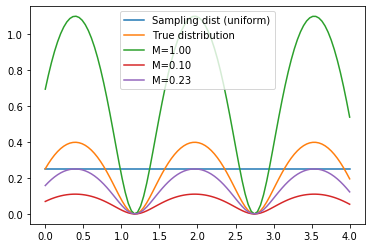

In [5]:
theta = np.linspace(0, 4, 100)
target = np.log(2 + np.sin(4 * theta))
plt.plot(theta, 1/4 * np.ones_like(theta), label='Sampling dist (uniform)')
plt.plot(theta, target / 2.76, label='True distribution')
for M in [1, 0.1, 1/np.log(81)]:
    plt.plot(theta, M * target, label=f'M={M:0.2f}')
    
plt.legend()

### Q2.2 (optional)

Explain what's special about the target distribution when for $M=\frac{1}{4\log(3)}$, and why.

**Answer**: This is the largest possible value of $M$ that we can use where the target distribution is always less than or equal to the sampling distribution (assuming we're sampling from Uniform$[0, 4]$).

I found it by looking at the maximum value of the target distribution where $M=1$. This function, $\log(2+\sin(4\theta))$, is maximized when $\sin(\cdot) = 1$ (since that's the largest possible value for the sine function), in which case we obtain $\log(3)$. Dividing the Uniform$[0, 4]$ density by this value, I obtain $\frac{1}{4\log(3)}$.

### Q2.3

Assume $a=4$, set $M=0.1$, and use rejection sampling to draw 1000 samples from $p(\theta)$. How many of your samples were accepted? Using your samples, estimate the variance of $p(\theta)$. 

*Hint: You may find it helpful to borrow some code from the lecture notebook to solve this problem, but make sure you're using the right distributions!*

In [6]:
M = 0.1
# M = 1/(4 * np.log(3))

# These two functions are modified from lecture
def target(theta):
    """The unnormalized distribution we want to sample from"""
    return np.log(2+np.sin(4*theta)) * M

def uniform_sampling_dist(x):
    """PDF of distribution we're sampling from: Uniform[0, 4]"""
    return stats.uniform.pdf(x, 0, 4)

def rejection_sample_uniform(num_samples=100):
    # Generate proposals for samples: these are x-values.
    # We'll keep some and reject the rest.
    proposals = np.random.uniform(low=0, high=4, size=num_samples)
    
    # Acceptance probability is the ratio of the two curves
    # This line was incorrect in the version of the notebook
    # used by Prof. Steinhardt in lecture.
    accept_probs = target(proposals) / uniform_sampling_dist(proposals)
    
    print('Max accept prob: %.3f' % np.max(accept_probs))
    
    # For each sample, we make a decision whether or not to accept.
    # Convince yourself that this line makes that decision for each
    # sample with prob equal to the value in "accept_probs"!
    accept = np.random.uniform(size=num_samples) < accept_probs
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]


In [7]:
samples = rejection_sample_uniform(1000)
print("Variance", np.var(samples))

Max accept prob: 0.439
Accepted 293 out of 1000 proposals
Variance 1.5873735754099414


### Q2.4 

What is the mathematical relationship between the proportion of your samples that were accepted (call it $p_A$) and the normalizing constant $Z$?

*Hint: look at the magic numbers in the lecture notebook. How are they related to the normalizing constants and the acceptance probabilities?*

**Answer**: In the run above, my acceptance probability was 0.293. 

What's the relationship between $p_A = 0.293$, $Z = 2.76$, and $M = 0.1$? It looks like it might be $p_A = MZ$.

Let's try experimenting with even more samples:

In [8]:
samples = rejection_sample_uniform(100000)

Max accept prob: 0.439
Accepted 27503 out of 100000 proposals


This time, it looks a lot closer to 0.276, which is what we'd get by multiplying $M$ and $Z$. What happens if we change $M$?

In [9]:
M = 1/(4*np.log(3))
Z = 2.76
print("M * Z = ", M * Z)
samples = rejection_sample_uniform(100000)

M * Z =  0.6280650663725177
Max accept prob: 1.000
Accepted 62815 out of 100000 proposals


This seems like strong evidence for $p_A = MZ$.